In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [5]:
df = pd.read_csv('mhealth_raw_data.csv')

In [6]:
print("Dataset Head:\n", df.head())
print("\nDataset Info:\n", df.info())
print("\nDataset Description:\n", df.describe())
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicates:\n", df.duplicated().sum())
print("\nActivity Distribution:\n", df['Activity'].value_counts())

Dataset Head:
       alx     aly      alz       glx      gly      glz     arx     ary  \
0  2.1849 -9.6967  0.63077  0.103900 -0.84053 -0.68762 -8.6499 -4.5781   
1  2.3876 -9.5080  0.68389  0.085343 -0.83865 -0.68369 -8.6275 -4.3198   
2  2.4086 -9.5674  0.68113  0.085343 -0.83865 -0.68369 -8.5055 -4.2772   
3  2.1814 -9.4301  0.55031  0.085343 -0.83865 -0.68369 -8.6279 -4.3163   
4  2.4173 -9.3889  0.71098  0.085343 -0.83865 -0.68369 -8.7008 -4.1459   

        arz      grx     gry       grz  Activity   subject  
0  0.187760 -0.44902 -1.0103  0.034483         0  subject1  
1  0.023595 -0.44902 -1.0103  0.034483         0  subject1  
2  0.275720 -0.44902 -1.0103  0.034483         0  subject1  
3  0.367520 -0.45686 -1.0082  0.025862         0  subject1  
4  0.407290 -0.45686 -1.0082  0.025862         0  subject1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215745 entries, 0 to 1215744
Data columns (total 14 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    -----

In [7]:
# Rename 'Activity' to 'label' for consistency
df = df.rename(columns={'Activity': 'label'})

# Define activity labels
activity_labels = {
    0: 'none',
    1: 'standing still',
    2: 'sitting and relaxing',
    3: 'lying down',
    4: 'walking',
    5: 'climbing stairs',
    6: 'waist bends forward',
    7: 'frontal elevation of arm',
    8: 'knee bending',
    9: 'cycling',
    10: 'jogging',
    11: 'running',
    12: 'jump front and back'
}

# Convert 'label' to numeric
df['label'] = pd.to_numeric(df['label'], errors='coerce')

In [8]:
# Handle imbalance (e.g., label 0)
activity_zero = df[df['label'] == 0]
other_activities = df[df['label'] != 0]
sampled_activity_zero = activity_zero.sample(n=len(other_activities), random_state=42)
df_balanced = pd.concat([sampled_activity_zero, other_activities]).reset_index(drop=True)
print("\nBalanced Activity Distribution:\n", df_balanced['label'].value_counts())


Balanced Activity Distribution:
 label
0     343195
1      30720
2      30720
3      30720
4      30720
9      30720
5      30720
11     30720
10     30720
7      29441
8      29337
6      28315
12     10342
Name: count, dtype: int64


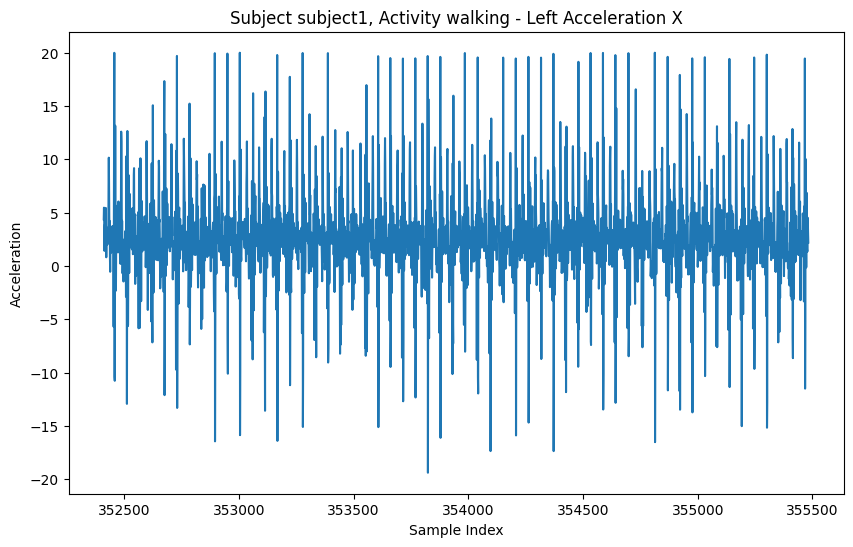

In [9]:
subject_id = 'subject1'  # Adjust based on actual format in dataset
activity_id = 4  # walking
subject_data = df_balanced[df_balanced['subject'] == subject_id]
activity_data = subject_data[subject_data['label'] == activity_id]
left_acc_x = activity_data['alx']  # Using 'alx' as a proxy for acceleration X
plt.figure(figsize=(10, 6))
plt.plot(left_acc_x)
plt.title(f'Subject {subject_id}, Activity {activity_labels[activity_id]} - Left Acceleration X')
plt.xlabel('Sample Index')
plt.ylabel('Acceleration')
plt.show()

In [10]:
numeric_columns = df_balanced.columns.drop(['label', 'subject'])
for col in numeric_columns:
    lower = df_balanced[col].quantile(0.01)
    upper = df_balanced[col].quantile(0.99)
    df_balanced = df_balanced[(df_balanced[col] >= lower) & (df_balanced[col] <= upper)]

In [12]:
X = df_balanced.drop(['label', 'subject'], axis=1)
y = df_balanced['label']
scaler = preprocessing.RobustScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [14]:
def summarize_results(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)
    print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
    print("Precision:", metrics.precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", metrics.recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score:", metrics.f1_score(y_true, y_pred, average='weighted'))

summarize_results(y_test, y_pred_rf)


Confusion Matrix:
 [[49351  1008   907   541   189    79   190   399   310   666   227    61
      4]
 [  338  5802     0     0     0     0     4     0     0     0     0     0
      0]
 [    1     0  6142     0     0     0     0     0     0     0     0     0
      0]
 [    1     0     0  4183     0     0     0     0     0     0     0     0
      0]
 [ 4176     0     0     0  1542     0     0     0     0     0     0     0
      0]
 [ 3564     0     0     0     5  1036     0     0    35     0     0     0
      0]
 [ 3880     2     0     0     0     0  1769     0     0     0     0     0
      0]
 [ 1597     1     0     0     0     0    15  3548     0     0     0     0
      0]
 [ 3409     0     0     0     0     0     0     0  2392     0     0     0
      0]
 [  665     0     0     0     0     0     0     0     2  4257     0     0
      0]
 [  938     0     0     0     0     0     0     0     0     0  2284    25
      0]
 [  787     0     0     0     1     0     0     0     0     0    18

In [15]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
print("\nTop 5 Feature Importances:\n", feature_importance.sort_values('importance', ascending=False).head())


Top 5 Feature Importances:
    feature  importance
2      alz    0.116185
1      aly    0.099695
9      grx    0.097428
7      ary    0.090257
10     gry    0.087519


In [17]:
# Example: Simulate new sensor data with 12 features (matching X columns)
new_data = np.array([[2.1849, -9.6967, 0.63076999, 0.0139, -0.84053, -0.58762, -8.6499, -4.5781, 0.18775995, 0.44902, -1.0103, 0.034483]])  # Single sample with 12 features

# Scale the new data using the same scaler
new_data_scaled = scaler.transform(new_data)

# Predict the activity
predicted_label = rf.predict(new_data_scaled)[0]
predicted_activity = activity_labels.get(predicted_label, 'unknown')

print(f"\nPredicted Activity for New Data: {predicted_activity} (Label: {predicted_label})")

# Optional: Confidence score (probability) for the prediction
predicted_proba = rf.predict_proba(new_data_scaled)
print("Prediction Probabilities:\n", dict(zip(activity_labels.values(), predicted_proba[0])))


Predicted Activity for New Data: none (Label: 0)
Prediction Probabilities:
 {'none': np.float64(0.7598052376882936), 'standing still': np.float64(0.00793210211849761), 'sitting and relaxing': np.float64(0.024726999877190747), 'lying down': np.float64(0.0), 'walking': np.float64(0.04317237074450557), 'climbing stairs': np.float64(0.020623099241860992), 'waist bends forward': np.float64(0.057394581184549404), 'frontal elevation of arm': np.float64(0.02348603759897778), 'knee bending': np.float64(0.02590639564213184), 'cycling': np.float64(0.014685467714118668), 'jogging': np.float64(0.00982244319162633), 'running': np.float64(0.005494129239377523), 'jump front and back': np.float64(0.006951135758870173)}


c:\Program Files\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
